# Splicing Analysis

Analysis of the unique splice junctions detected by nanopore before and after error correction:

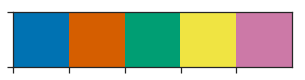

In [2]:
import sys
import os
from glob import glob
import re
import random
import json
import itertools as it
from collections import defaultdict, Counter

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from Bio import motifs
from Bio.motifs import matrix
from Bio.Alphabet.IUPAC import unambiguous_dna
from Bio.Seq import Seq
import pysam
from joblib import Parallel, delayed

#from upsetplot import plot as upsetplot, UpSet
#from upsetplot.data import from_sets


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

To get the splice junctions which are present in the reference we'll first use cgat gtf2gtf to create an intron gtf and then read these in with python

In [3]:
%%bash
source activate miCLIP

cat /cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.gtf |
cgat gtf2gtf --method=set-gene-to-transcript -L /dev/null |
cgat gtf2gtf --method=exons2introns -L /dev/null |
cgat gtf2gtf --method=set-transcript-to-gene -L /dev/null \
 > araport_introns.gtf

bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `BASH_FUNC_module'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `BASH_FUNC_ml'


In [4]:
%%bash
source activate miCLIP

cat /cluster/ggs_lab/mtparker/Arabidopsis_annotations/atRTD/2016_update/AtRTD2_19April2016.gtf |
cgat gtf2gtf --method=set-gene-to-transcript -L /dev/null |
cgat gtf2gtf --method=exons2introns -L /dev/null |
cgat gtf2gtf --method=set-transcript-to-gene -L /dev/null \
 > atrtd2_introns.gtf

bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `BASH_FUNC_module'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `BASH_FUNC_ml'


In [5]:
def read_pwm(pwm_fn, length):
    pwm = pd.read_csv(pwm_fn, sep='\t', skiprows=8)
    assert len(pwm) == length
    pwm = matrix.PositionWeightMatrix(
        unambiguous_dna, pwm.to_dict('list')
    )
    lod = pwm.log_odds()
    max_score = pd.DataFrame(lod).max(1).sum()
    return lod, max_score


RC = str.maketrans('ACGTSWRYN', 'TGCASWYRN')


def rev_comp(seq):
    return seq.translate(RC)[::-1]


class SpliceClassifier(object):

    def __init__(self, fasta_fn, donor_pwm_fns, acceptor_pwm_fns, 
                 class_names):
        assert len(donor_pwm_fns) == len(acceptor_pwm_fns) == len(class_names)
        self._fasta = pysam.FastaFile(fasta_fn)
        self._class_names = [tuple(k.split('_')) for k in class_names]
        self._donor_pwms = {
            k: read_pwm(fn, 13) for k, fn in zip(self._class_names, donor_pwm_fns)
        }
        self._acceptor_pwms = {
            k: read_pwm(fn, 17) for k, fn in zip(self._class_names, acceptor_pwm_fns)
        }

    def _get_seq(self, chrom, intron_start, intron_end, strand):
        if strand == '+':
            donor = self._fasta.fetch(chrom, intron_start - 3, intron_start + 10).upper()
            acceptor = self._fasta.fetch(chrom, intron_end - 14, intron_end + 3).upper()
        else:
            donor = rev_comp(
                self._fasta.fetch(chrom, intron_end - 10, intron_end + 3).upper()
            )
            acceptor = rev_comp(
                self._fasta.fetch(chrom, intron_start - 3, intron_start + 14).upper()
            )
        return Seq(donor, unambiguous_dna), Seq(acceptor, unambiguous_dna)

    def _rescale_score(self, score, max_score):
        # rescale scores between 50 and 100
        # in the Sheth paper scores less than 0 are scaled
        # between 0 and 50 but since we are only classifying
        # above 60 anyway it doesn't matter
        return (50 / max_score) * max(0, score) + 50

    def _calc_donor(self, seq, k):
        pwm, max_score = self._donor_pwms[k]
        donor_score = pwm.calculate(seq)
        return self._rescale_score(donor_score, max_score)

    def _calc_acceptor(self, seq, k):
        pwm, max_score = self._acceptor_pwms[k]
        acceptor_score = pwm.calculate(seq)
        return self._rescale_score(acceptor_score, max_score)

    def classify(self, chrom, intron_start, intron_end, strand):
        best_class = None
        best_donor = 60
        best_acceptor = 60
        donor, acceptor = self._get_seq(chrom, intron_start, intron_end, strand)
        is_canon = (donor[3:5] == 'GT') & (acceptor[12:14] == 'AG')
        for k in self._class_names:
            donor_score = self._calc_donor(donor, k)
            acceptor_score = self._calc_acceptor(acceptor, k)
            if donor_score < best_donor or acceptor_score < best_acceptor:
                continue
            elif k[0]  == 'U12' and donor_score > 75 and acceptor_score > 65:
                best_class = k
                best_donor = donor_score
                best_acceptor = acceptor_score
            else:
                best_class = k
                best_donor = donor_score
                best_acceptor = acceptor_score
        return is_canon, ' '.join(best_class) if best_class else None


def get_gtf_introns(gtf_fn, fasta_fn,
                    donor_pwm_fns, acceptor_pwm_fns,
                    splice_class_names):
    canon = {}
    non_canon = {}
    splice_classifier = SpliceClassifier(
        fasta_fn, donor_pwm_fns, acceptor_pwm_fns, splice_class_names
    )
    with open(gtf_fn) as gtf, pysam.FastaFile(fasta_fn) as f:
        for record in gtf:
            record = record.split()
            chrom = re.sub('^Chr', '', record[0])
            chrom = re.sub('C', 'Pt', chrom)
            chrom = re.sub('M$', 'Mt', chrom)
            start = int(record[3]) - 1
            end = int(record[4])
            strand = record[6]
            is_canon, k = splice_classifier.classify(chrom, start, end, strand)
            if is_canon:
                canon[f'{chrom}:{start}-{end}({strand})'] = k
            else:
                non_canon[f'{chrom}:{start}-{end}({strand})'] = k
    return canon, non_canon


def test_read_is_fwd(dtype='illumina'):
    if dtype == 'illumina':
        def is_fwd_ill(aln):
            if aln.is_reverse:
                if aln.is_read1:
                    return True
                else:
                    return False
            else:
                if aln.is_read1:
                    return False
                else:
                    return True
        return is_fwd_ill
    elif dtype == 'nanopore':
        def is_fwd_ont(aln):
            return not aln.is_reverse
        return is_fwd_ont
        


def get_bam_introns(bam_fn, aln_dtype, fasta_fn,
                    donor_pwm_fns, acceptor_pwm_fns,
                    splice_class_names):
    canon = {}
    non_canon = {}
    splice_classifier = SpliceClassifier(
        fasta_fn, donor_pwm_fns, acceptor_pwm_fns, splice_class_names
    )
    is_fwd = test_read_is_fwd(aln_dtype)
    with pysam.AlignmentFile(bam_fn) as bam, pysam.FastaFile(fasta_fn) as fasta:
        for chrom, strand in it.product(bam.references, ['+', '-']):
            if strand == '+':
                introns = bam.find_introns(
                    aln for aln in bam.fetch(chrom) if is_fwd(aln)
                )
            else:
                introns = bam.find_introns(
                    aln for aln in bam.fetch(chrom) if not is_fwd(aln)
                )
            for (start, end), count in introns.items():
                is_canon, k = splice_classifier.classify(chrom, start, end, strand)
                if is_canon:
                    canon[f'{chrom}:{start}-{end}({strand})'] = (k, count)
                else:
                    non_canon[f'{chrom}:{start}-{end}({strand})'] = (k, count)
    return canon, non_canon


def merge_counts(counts):
    merged = defaultdict(lambda: [None, 0])
    for c in counts:
        for k, v in c.items():
            merged[k][0] = v[0]
            merged[k][1] += v[1]
    return merged


def get_multibam_introns(bam_fns, aln_dtype, fasta_fn,
                         donor_pwm_fns, acceptor_pwm_fns,
                         splice_class_names):
    n_proc = min(len(bam_fns), 12)
    args = (aln_dtype, fasta_fn,
            donor_pwm_fns, acceptor_pwm_fns,
            splice_class_names)
    introns = Parallel(n_jobs=n_proc)(
        delayed(get_bam_introns)(bam_fn, *args) for bam_fn in bam_fns
    )
    canon, noncanon = zip(*introns)
    canon = merge_counts(canon)
    noncanon = merge_counts(noncanon)
    return canon, noncanon

In [6]:
donor_fns = sorted(glob('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_*_donor.pwm'))
acceptor_fns = sorted(glob('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_*_acceptor.pwm'))
list(zip(donor_fns, acceptor_fns))

[('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U12_ATAC_donor.pwm',
  '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U12_ATAC_acceptor.pwm'),
 ('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U12_GTAG_donor.pwm',
  '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U12_GTAG_acceptor.pwm'),
 ('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U2_GCAG_donor.pwm',
  '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U2_GCAG_acceptor.pwm'),
 ('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U2_GTAG_donor.pwm',
  '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline/scripts/DRS_details/position_weight_matricies/A_thaliana_U2_G

In [7]:
class_names = [re.search('A_thaliana_(U\d+_[ACGT]{4})_donor', fn).group(1) for fn in donor_fns]
class_names

['U12_ATAC', 'U12_GTAG', 'U2_GCAG', 'U2_GTAG']

In [8]:
fasta = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/TAIR10/ensembl/release_35/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa'
atrtd2_canon, atrtd2_non_canon = get_gtf_introns('atrtd2_introns.gtf', fasta, donor_fns, acceptor_fns, class_names)
araport11_canon, araport11_non_canon = get_gtf_introns('araport_introns.gtf', fasta, donor_fns, acceptor_fns, class_names)

In [9]:
len(araport11_canon), len(araport11_non_canon)

(133457, 2310)

For the Illumina and Nanopore datasets we use pysam to identify the unique introns from the reads

In [10]:
illumina_data = glob(
    '/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/vir_fpa_35SFPA_rnaseq/aligned_data/col0_*/Aligned.sorted.bam'
)

ill_canon, ill_noncanon = get_multibam_introns(
    illumina_data, 'illumina', fasta, donor_fns, acceptor_fns, class_names
)

In [11]:
ont_data = [
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/TAIR10/201901_col0_2917.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/TAIR10/201901_col0_2919.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2.bam'
]

ont_canon, ont_noncanon = get_multibam_introns(
    ont_data, 'nanopore', fasta, donor_fns, acceptor_fns, class_names
)

In [12]:
ec_ont_data = glob(
    '/cluster/ggs_lab/mtparker/proovread_error_correction_pipeline/col0_error_corrected_fwd_strand_only/alignments/*/*.bam'
)
ec_ont_canon, ec_ont_noncanon = get_multibam_introns(
    ec_ont_data, 'nanopore', fasta, donor_fns, acceptor_fns, class_names
)

Heres the code for making pretty upset plots:

In [13]:
from __future__ import print_function, division, absolute_import

import itertools
from functools import reduce
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.tight_layout import get_renderer

from upsetplot.data import from_sets


def _process_data(data, sort_by, sort_sets_by,
                  bootstrap_exp, global_set_size,
                  ci, nboot, discard_empty,
                  discard_union_difference):
    # check all indices are vertical
    assert all(set([True, False]) >= set(level) for level in data.index.levels)
    if not data.index.is_unique:
        data = (data
                .groupby(level=list(range(data.index.nlevels)))
                .sum())

    totals = []
    for i in range(data.index.nlevels):
        idxslice = pd.IndexSlice[(slice(None),) * i + (True,)]
        # FIXME: can get IndexingError if level only contains False
        totals.append(data.loc[idxslice].sum())
    totals = pd.Series(totals, index=data.index.names)
    data, totals = _order_data(data, totals, sort_by, sort_sets_by)
    if discard_union_difference:
        data = data[[any(x) for x in data.index.values]]
    if discard_empty:
        data = data[data.astype(bool)]

    if bootstrap_exp:
        if global_set_size is None:
            global_set_size = np.nansum(data.values)
        exp_med, exp_err = _bootstrap_expected(
            totals, global_set_size, ci, nboot)
        exp_med = exp_med[data.index]
        exp_err = exp_err[data.index]
    else:
        exp_med, exp_err = None, None

    return data, totals, exp_med, exp_err


def _order_data(data, totals, sort_by, sort_sets_by):

    if sort_sets_by == 'cardinality':
        totals.sort_values(ascending=False, inplace=True)

    elif sort_sets_by is not None:
        raise ValueError('Unknown sort_sets_by: %r' % sort_sets_by)
    else:
        totals = totals.reindex(data.index.names)

    data = data.reorder_levels(totals.index.values)

    if isinstance(sort_by, pd.core.index.MultiIndex):
        data = data.reindex(sort_by)
    elif sort_by == 'cardinality':
        data = data.sort_values(ascending=False)
    elif sort_by == 'degree':
        comb = itertools.combinations
        o = pd.DataFrame([{name: True for name in names}
                          for i in range(data.index.nlevels + 1)
                          for names in comb(data.index.names, i)],
                         columns=data.index.names)
        o.fillna(False, inplace=True)
        o = o.astype(bool)
        o.set_index(data.index.names, inplace=True)
        # FIXME: should use reindex(index=...) ??
        data = data.loc[o.index]
    else:
        raise ValueError('Unknown sort_by: %r' % sort_by)
    return data, totals


def _set_intersections(sets):
    for i in range(1, len(sets) + 1):
        yield from itertools.combinations(sets, i)


def _confidence_interval(a, which=95):
    p = 50 - which / 2, 50 + which / 2
    l, u = np.percentile(a, p)
    return np.median(a) - l, u - np.median(a)


def _bootstrap_expected(totals, global_set_size, ci, nboot):
    global_set = np.arange(global_set_size)
    intersections = list(_set_intersections(totals.index.values))
    exp_overlaps = []
    for _ in range(nboot):
        sampled_sets = OrderedDict()
        for set_name, set_size in totals.iteritems():
            sampled_sets[set_name] = set(np.random.choice(
                global_set, size=set_size, replace=False))
        sampled_sets['global'] = set(global_set)
        agg = from_sets(sampled_sets)
        agg = agg.groupby(agg.index.names[:-1]).sum()
        exp_overlaps.append(agg)

    ci_func = np.std if ci == 'std' else lambda x: _confidence_interval(x, ci)
    exp_overlaps = pd.concat(exp_overlaps, axis=1)
    exp_med = exp_overlaps.median(axis=1)
    exp_err = exp_overlaps.apply(ci_func, axis=1, raw=True)
    return exp_med, exp_err      


class _Transposed:
    """Wrap an object in order to transpose some plotting operations

    Attributes of obj will be mapped.
    Keyword arguments when calling obj will be mapped.

    The mapping is not recursive: callable attributes need to be _Transposed
    again.
    """

    def __init__(self, obj):
        self.__obj = obj

    def __getattr__(self, key):
        return getattr(self.__obj, self._NAME_TRANSPOSE.get(key, key))

    def __call__(self, *args, **kwargs):
        return self.__obj(*args, **{self._NAME_TRANSPOSE.get(k, k): v
                                    for k, v in kwargs.items()})

    _NAME_TRANSPOSE = {
        'width': 'height',
        'height': 'width',
        'hspace': 'wspace',
        'wspace': 'hspace',
        'hlines': 'vlines',
        'vlines': 'hlines',
        'bar': 'barh',
        'barh': 'bar',
        'yerr': 'xerr',
        'xerr': 'yerr',
        'xaxis': 'yaxis',
        'yaxis': 'xaxis',
        'left': 'bottom',
        'right': 'top',
        'top': 'right',
        'bottom': 'left',
        'sharex': 'sharey',
        'sharey': 'sharex',
        'get_figwidth': 'get_figheight',
        'get_figheight': 'get_figwidth',
        'set_figwidth': 'set_figheight',
        'set_figheight': 'set_figwidth',
    }


def _transpose(obj):
    if isinstance(obj, str):
        return _Transposed._NAME_TRANSPOSE.get(obj, obj)
    return _Transposed(obj)


def _identity(obj):
    return obj


class UpSet:
    """Manage the data and drawing for a basic UpSet plot

    Primary public method is :meth:`plot`.

    Parameters
    ----------
    data : pandas.Series
        Values for each set to plot.
        Should have multi-index where each level is binary,
        corresponding to set membership.
    bootstrap_expected: bool
        Whether to plot expected intersection size bars using global
        set size parameter (Default False).
    global_set_size : int or None
        Size of whole population sets are drawn from. If None,
        all examples are assumed to be present in union of sets.
        Only required for computing expected bootstraps.
    orientation : {'horizontal' (default), 'vertical'}
        If horizontal, intersections are listed from left to right.
    sort_by : {'cardinality', 'degree'}
        If 'cardinality', set intersections are listed from largest to
        smallest value.
        If 'degree', they are listed in order of the number of sets
        intersected.
    sort_sets_by : {'cardinality', None}
        Whether to sort the overall sets by total cardinality, or leave them
        in the provided order.
    facecolor : str
        Color for bar charts and dots.
    with_lines : bool
        Whether to show lines joining dots in the matrix, to mark multiple sets
        being intersected.
    element_size : float or None
        Side length in pt. If None, size is estimated to fit figure
    intersections_plot_elements : int
        The intersections plot should be large enough to fit this many matrix
        elements.
    totals_plot_elements : int
        The totals plot should be large enough to fit this many matrix
        elements.
    """

    def __init__(self, data, bootstrap_expected=False,
                 global_set_size=None, ci=95, n_boot=100,
                 orientation='horizontal', sort_by='degree',
                 sort_sets_by='cardinality',
                 discard_empty=False, discard_union_difference=True,
                 facecolor='black', exp_facecolor='lightgrey',
                 with_lines=True, element_size=32, plot_reverse=False,
                 intersection_plot_elements=6, totals_plot_elements=2):

        self._bootstrap_expected = bootstrap_expected
        self._err_type = 'std' if ci == 'std' else 'ci'
        self._horizontal = orientation == 'horizontal'
        self._reorient = _identity if self._horizontal else _transpose
        self._facecolor = facecolor
        self._exp_facecolor = exp_facecolor
        self._with_lines = with_lines
        self._element_size = element_size
        self._totals_plot_elements = totals_plot_elements
        self._intersection_plot_elements = intersection_plot_elements
        self._plot_reverse = plot_reverse

        (self.intersections, self.totals,
         self.exp_med, self.exp_err) = _process_data(
            data,
            sort_by=sort_by,
            sort_sets_by=sort_sets_by,
            bootstrap_exp=bootstrap_expected,
            global_set_size=global_set_size,
            ci=ci, nboot=n_boot,
            discard_empty=discard_empty,
            discard_union_difference=discard_union_difference
        )
        if not self._horizontal:
            self.intersections = self.intersections[::-1]
            if bootstrap_expected:
                self.exp_med = self.exp_med[::-1]
                self.exp_err = self.exp_err[::-1]

    def _swapaxes(self, x, y):
        if self._horizontal:
            return x, y
        return y, x

    def make_grid(self, fig=None):
        """Get a SubplotSpec for each Axes, accounting for label text width
        """
        n_cats = len(self.totals)
        n_inters = len(self.intersections)

        if fig is None:
            fig = plt.gcf()

        # Determine text size to determine figure size / spacing
        r = get_renderer(fig)
        t = fig.text(0, 0, '\n'.join(self.totals.index.values))
        textw = t.get_window_extent(renderer=r).width
        t.remove()

        MAGIC_MARGIN = 10  # FIXME
        figw = self._reorient(fig.get_window_extent(renderer=r)).width
        if self._element_size is None:
            colw = (figw - textw - MAGIC_MARGIN) / (len(self.intersections) +
                                                    self._totals_plot_elements)
        else:
            fig = self._reorient(fig)
            render_ratio = figw / fig.get_figwidth()
            colw = self._element_size / 72 * render_ratio
            figw = (colw * (len(self.intersections) +
                            self._totals_plot_elements) +
                    MAGIC_MARGIN + textw)
            fig.set_figwidth(figw / render_ratio)
            fig.set_figheight((colw * (n_cats +
                                       self._intersection_plot_elements)) /
                              render_ratio)

        text_nelems = int(np.ceil(figw / colw - (len(self.intersections) +
                                                 self._totals_plot_elements)))

        GS = self._reorient(matplotlib.gridspec.GridSpec)
        gridspec = GS(*self._swapaxes(n_cats +
                                      self._intersection_plot_elements,
                                      n_inters + text_nelems +
                                      self._totals_plot_elements),
                      hspace=1)
        if self._horizontal:
            if not self._plot_reverse:
                return {'intersections': gridspec[:-n_cats, -n_inters:],
                        'matrix': gridspec[-n_cats:, -n_inters:],
                        'shading': gridspec[-n_cats:, :],
                        'totals': gridspec[-n_cats:, :self._totals_plot_elements],
                        'gs': gridspec}
            else:
                return {'intersections': gridspec[n_cats:, :n_inters],
                        'matrix': gridspec[:n_cats, :n_inters],
                        'shading': gridspec[:n_cats, :],
                        'totals': gridspec[:n_cats, -self._totals_plot_elements:],
                        'gs': gridspec}
        else:
            return {'intersections': gridspec[-n_inters:, n_cats:],
                    'matrix': gridspec[-n_inters:, :n_cats],
                    'shading': gridspec[:, :n_cats],
                    'totals': gridspec[:self._totals_plot_elements, :n_cats],
                    'gs': gridspec}

    def plot_matrix(self, ax):
        """Plot the matrix of intersection indicators onto ax
        """
        ax = self._reorient(ax)
        data = self.intersections
        n_sets = data.index.nlevels

        idx = np.flatnonzero(data.index.to_frame()[data.index.names].values)
        c = np.array(['lightgrey'] * len(data) * n_sets, dtype='O')
        if isinstance(self._facecolor, np.ndarray):
            c[idx] = np.repeat(self._facecolor, n_sets)[idx]
        else:
            c[idx] = self._facecolor
        x = np.repeat(np.arange(len(data)), n_sets)
        y = np.tile(np.arange(n_sets), len(data))
        if self._element_size is not None:
            s = (self._element_size * .5) ** 2
        else:
            # TODO: make s relative to colw
            s = 200
        ax.scatter(*self._swapaxes(x, y), c=c.tolist(), linewidth=1, s=s, edgecolors='white')

        if self._with_lines:
            line_data = (pd.Series(y[idx], index=x[idx])
                         .groupby(level=0)
                         .aggregate(['min', 'max']))
            ax.vlines(line_data.index.values,
                      line_data['min'], line_data['max'],
                      lw=2, colors=self._facecolor)

        tick_axis = ax.yaxis
        tick_axis.set_ticks(np.arange(n_sets))
        tick_axis.set_ticklabels(data.index.names,
                                 rotation=0 if self._horizontal else -90)
        ax.xaxis.set_visible(False)
        ax.tick_params(axis='both', which='both', length=0)
        if not self._horizontal:
            ax.yaxis.set_ticks_position('top')
        if self._plot_reverse:
            tick_axis.set_ticks_position('right')
        ax.set_frame_on(False)

    def plot_intersections(self, ax):
        """Plot bars indicating intersection size
        """
        
        ax = self._reorient(ax)
        width = 0.3 if self._bootstrap_expected else 0.8
        x = np.arange(len(self.intersections))
        obs_x = x - 0.15 if self._bootstrap_expected else x
        exp_x = x + 0.15
        if self.exp_err is not None:
            if self._err_type == 'std':
                exp_err = self.exp_err.values
            else:
                exp_err = np.array(self.exp_err.values.tolist()).T
        ax.bar(obs_x, self.intersections,
               width, color=self._facecolor,
               zorder=10, align='center',
               label='Obs')
        if self._bootstrap_expected:
            ax.bar(exp_x, self.exp_med, width,
                   color=self._exp_facecolor,
                   align='center',
                   label='Exp',
                   **{self._reorient('yerr'): exp_err})
            ax.legend(loc=0)
        ax.xaxis.set_visible(False)
        for x in ['top', 'bottom', 'right']:
            ax.spines[self._reorient(x)].set_visible(False)

        tick_axis = ax.yaxis
        tick_axis.grid(True)
        tick_axis.set_label('Intersection size')
        if self._plot_reverse:
            ax.invert_yaxis()
        # tick_axis.set_tick_params(direction='in')

    def plot_totals(self, ax):
        """Plot bars indicating total set size
        """
        orig_ax = ax
        ax = self._reorient(ax)
        ax.barh(np.arange(len(self.totals.index.values)), self.totals,
                .5, color="#252525", align='center')
        max_total = self.totals.max()
        if self._horizontal:
            orig_ax.set_xlim(max_total, 0)
        for x in ['top', 'left', 'right']:
            ax.spines[self._reorient(x)].set_visible(False)
        ax.yaxis.set_visible(False)
        ax.xaxis.grid(True)
        ax.patch.set_visible(False)
        if self._plot_reverse:
            ax.invert_xaxis()

    def plot_shading(self, ax):
        # alternating row shading (XXX: use add_patch(Rectangle)?)
        for i in range(0, len(self.totals), 2):
            rect = plt.Rectangle(self._swapaxes(0, i - .4),
                                 *self._swapaxes(*(1, .8)),
                                 facecolor='#f5f5f5', lw=0, zorder=0)
            ax.add_patch(rect)
        ax.set_frame_on(False)
        ax.tick_params(
            axis='both',
            which='both',
            left='off',
            right='off',
            bottom='off',
            top='off',
            labelbottom='off',
            labelleft='off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    def plot(self, fig=None):
        """Draw all parts of the plot onto fig or a new figure

        Parameters
        ----------
        fig : matplotlib.figure.Figure, optional
            Defaults to a new figure.

        Returns
        -------
        subplots : dict of matplotlib.axes.Axes
            Keys are 'matrix', 'intersections', 'totals', 'shading'
        """
        if fig is None:
            fig = plt.figure(figsize=(10, 6))
        specs = self.make_grid(fig)
        shading_ax = fig.add_subplot(specs['shading'])
        self.plot_shading(shading_ax)
        matrix_ax = self._reorient(fig.add_subplot)(specs['matrix'],
                                                    sharey=shading_ax)
        self.plot_matrix(matrix_ax)
        inters_ax = self._reorient(fig.add_subplot)(specs['intersections'],
                                                    sharex=matrix_ax)
        self.plot_intersections(inters_ax)
        totals_ax = self._reorient(fig.add_subplot)(specs['totals'],
                                                    sharey=matrix_ax)
        self.plot_totals(totals_ax)
        return {'matrix': matrix_ax,
                'intersections': inters_ax,
                'shading': shading_ax,
                'totals': totals_ax}


def plot(data, fig=None, **kwargs):
    """Make an UpSet plot of data on fig

    Parameters
    ----------
    data : pandas.Series
        Values for each set to plot.
        Should have multi-index where each level is binary,
        corresponding to set membership.
    fig : matplotlib.figure.Figure, optional
        Defaults to a new figure.
    kwargs
        Other arguments for :class:`UpSet`

    Returns
    -------
    subplots : dict of matplotlib.axes.Axes
        Keys are 'matrix', 'intersections', 'totals', 'shading'
    """
    return UpSet(data, **kwargs).plot(fig)


/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/clu

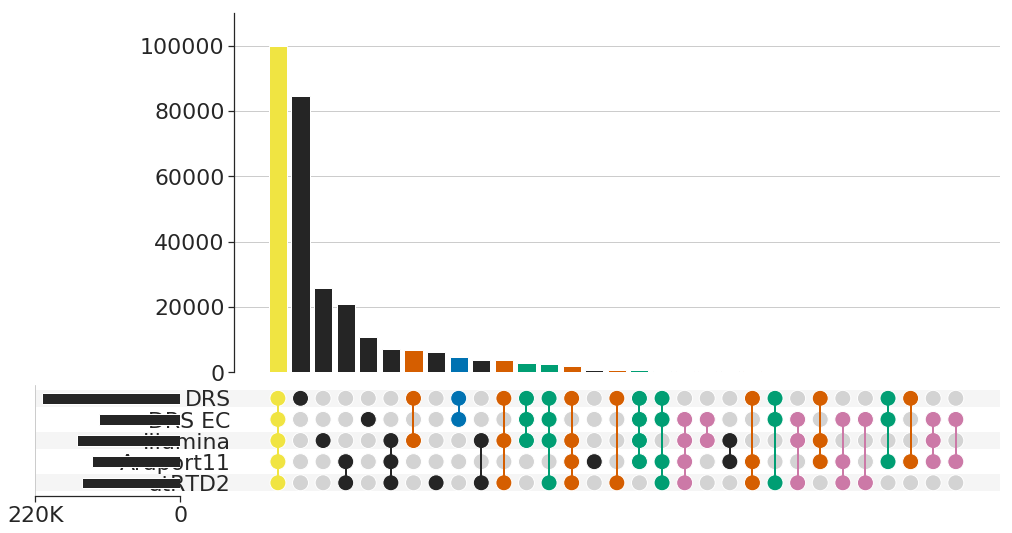

/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/clu

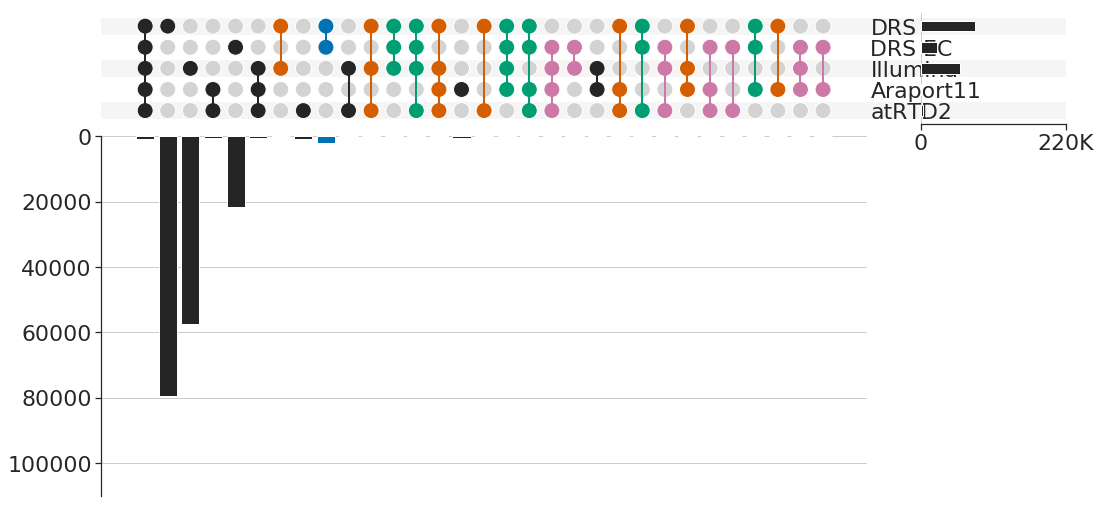

In [14]:
hexpal = pal.as_hex()

def plot_upsetplot(udata, order, intersection_ylim=110_000, totals_xlim=220_000, **kwargs):
    u = plot(udata, sort_by=order, sort_sets_by=None, **kwargs)
    if kwargs.get('plot_reverse', False):
        u['intersections'].set_ylim(intersection_ylim, 0)
        u['totals'].set_xlim(0, totals_xlim)
        u['totals'].set_xticks([0, totals_xlim])
        u['totals'].set_xticklabels(['0', f'{totals_xlim // 1000}K'])
    else:
        u['intersections'].set_ylim(0, intersection_ylim)
        u['totals'].set_xlim(totals_xlim, 0)
        u['totals'].set_xticks([totals_xlim, 0])
        u['totals'].set_xticklabels([f'{totals_xlim // 1000}K', '0'])
    return u

udata_canon = from_sets({
    'atRTD2': set(atrtd2_canon),
    'Araport11': set(araport11_canon),
    'Illumina': set(ill_canon),
    'DRS EC': set(ec_ont_canon),
    'DRS': set(ont_canon),
})

order = udata_canon.sort_values(ascending=False).index
facecolors = np.repeat('#252525', len(order))
facecolors[order.get_level_values('DRS').values.astype(bool) &
           order.get_level_values('DRS EC').values.astype(bool)] = hexpal[0]
facecolors[order.get_level_values('DRS').values.astype(bool) &
           order.get_level_values('DRS EC').values.astype(bool) &
           (np.sum(order.labels, axis=0) > 2)] = hexpal[2]
facecolors[order.get_level_values('DRS').values.astype(bool) &
           ~(order.get_level_values('DRS EC').values.astype(bool)) &
           (np.sum(order.labels, axis=0) >= 2)] = hexpal[1]
facecolors[~(order.get_level_values('DRS').values.astype(bool)) &
           order.get_level_values('DRS EC').values.astype(bool) &
           (np.sum(order.labels, axis=0) >= 2)] = hexpal[4]
facecolors[np.sum(order.labels, axis=0) == 5] = hexpal[3]


plot_upsetplot(
    udata_canon, order=order,
    totals_plot_elements=6,
    intersection_plot_elements=15,
    facecolor=facecolors
)

plt.savefig('upset_canon.svg')
plt.show()

udata_noncanon = from_sets({
    'atRTD2': set(atrtd2_non_canon),
    'Araport11': set(araport11_non_canon),
    'Illumina': set(ill_noncanon),
    'DRS EC': set(ec_ont_noncanon),
    'DRS': set(ont_noncanon),
})
facecolors[0] = '#252525'
ups = plot_upsetplot(
    udata_noncanon, order=order,
    totals_plot_elements=6,
    intersection_plot_elements=15,
    facecolor=facecolors,
    plot_reverse=True,
)

plt.savefig('upset_noncanon.svg')

plt.show()

Calculate the number of unsupported DRS splices:

In [15]:
def style_udata(udata_canon, udata_noncanon):

    def _style(x):
        c = '#555555' if x else '#ffffff'
        return f'background-color: {c}; color: {c}'

    udata_canon.name = 'Canonical'
    udata_noncanon.name = 'Noncanonical'
    udata = udata_canon.to_frame().join(udata_noncanon)
    df = udata.sort_values(by='Canonical', ascending=False).reset_index()
    styled = df.style.applymap(
        _style,
        subset=pd.IndexSlice[:, ['atRTD2', 'Araport11', 'Illumina', 'DRS EC', 'DRS']]
    )
    styled = styled.applymap(
        lambda x: 'background-color: white',
        subset=pd.IndexSlice[:, ['Canonical', 'Noncanonical']]
    )
    return styled.hide_index()

In [16]:
s = style_udata(udata_canon, udata_noncanon)

s.to_excel('splicing_upset_values.xlsx')
s

atRTD2,Araport11,Illumina,DRS EC,DRS,Canonical,Noncanonical
True,True,True,True,True,99966,805
False,False,False,False,True,84630,79377
False,False,True,False,False,25769,57298
True,True,False,False,False,20893,404
False,False,False,True,False,10882,21484
True,True,True,False,False,7301,545
False,False,True,False,True,6941,210
True,False,False,False,False,6256,879
False,False,False,True,True,4801,1894
True,False,True,False,False,3939,160


In [17]:
len(
    set(ont_canon).union(ont_noncanon).difference(
        set(atrtd2_canon).union(araport11_canon).union(ill_canon).union(
            set(atrtd2_non_canon).union(araport11_non_canon).union(ill_noncanon)
        )
    )
)

170702

In [18]:
len(
    set(ont_canon).union(ont_noncanon).difference(
        set(atrtd2_canon).union(araport11_canon).union(ill_canon).union(
            set(atrtd2_non_canon).union(araport11_non_canon).union(ill_noncanon)
        )
    )
) / len(set(ont_canon).union(ont_noncanon))

0.5840198708123495

Calculate the amount of Error corrected splices which are supported by both references and Illumina:

In [19]:
len(
    set(ec_ont_canon).intersection(
        set(atrtd2_canon).intersection(araport11_canon).intersection(ill_canon)
    )
)

100450

In [22]:
len(
    set(ec_ont_canon).union(ec_ont_noncanon).difference(
        set(atrtd2_canon).union(araport11_canon).union(ill_canon).union(
            set(atrtd2_non_canon).union(araport11_non_canon).union(ill_noncanon)
        )
    )
)

39061

In [21]:
len(
    set(ec_ont_canon).union(ec_ont_noncanon).difference(
        set(atrtd2_canon).union(araport11_canon).union(ill_canon).union(
            set(atrtd2_non_canon).union(araport11_non_canon).union(ill_noncanon)
        )
    )
) / len(set(ont_canon).union(ont_noncanon))

0.13363873987300198

In [20]:
len(
    set(ec_ont_canon).intersection(
        set(atrtd2_canon).intersection(araport11_canon).intersection(ill_canon)
    )
) / len(
    ec_ont_canon
)

0.8144154370034052

Calculate the percentage of reference splices captured by the EC nanopore:

In [21]:
all_annotated = (set(atrtd2_canon).union(atrtd2_non_canon)
                                  .union(araport11_canon)
                                  .union(araport11_non_canon))
all_atrtd2 = set(atrtd2_canon).union(atrtd2_non_canon)
all_araport11 = set(araport11_canon).union(araport11_non_canon)

all_ec_ont = set(ec_ont_canon).union(ec_ont_noncanon)

print('Amount of all annotated splices captured:')
print(len(all_annotated.intersection(all_ec_ont)), len(all_annotated.intersection(all_ec_ont)) / len(all_annotated))
print('Araport')
print(len(all_araport11.intersection(all_ec_ont)), len(all_araport11.intersection(all_ec_ont)) / len(all_araport11))
print('atRTD2')
print(len(all_atrtd2.intersection(all_ec_ont)), len(all_atrtd2.intersection(all_ec_ont)) / len(all_atrtd2))

Amount of all annotated splices captured:
105317 0.682277259152247
Araport
102486 0.754866793845338
atRTD2
104686 0.6889775180329595


Calculate the number of splice sites in the nanopore data and in illumina data that are not in either reference:

In [22]:
len(set(ec_ont_canon).intersection(ill_canon).difference(all_annotated))

3234

In [23]:
MATCH_OR_DELETION = {0, 2, 7, 8}
REFSKIP = 3

def find_splices(aln):
    strand = ['+', '-'][aln.is_reverse]
    splices = []
    base_position = aln.pos
    for op, nt in aln.cigartuples:
        if op in MATCH_OR_DELETION: 
            base_position += nt
        elif op == REFSKIP: 
            junc_start = base_position
            base_position += nt
            splices.append(f'{aln.reference_name}:{junc_start}-{base_position}({strand})')
    return tuple(splices)


def get_linked_splices(bam_fn):
    linked_splices = set()
    with pysam.AlignmentFile(bam_fn) as bam:
        for aln in bam.fetch():
            linked_splices.add(find_splices(aln))
    return linked_splices

In [24]:
ec_fulllength_data = [
    '/cluster/ggs_lab/mtparker/adapter_DRS_pipeline/201904_col0_error_corrected2_2916/aligned_data/201902_col0_adapter_error_corrected_2916.passes.bam',
    '/cluster/ggs_lab/mtparker/adapter_DRS_pipeline/201904_col0_error_corrected2_2918/aligned_data/201902_col0_adapter_error_corrected_2918.passes.bam'
]

In [25]:
ec_ont_lnkd_splices = set()
for bam_fn in ec_fulllength_data:
    ec_ont_lnkd_splices = ec_ont_lnkd_splices.union(get_linked_splices(bam_fn))

In [26]:
len(ec_ont_lnkd_splices)

21723

In [27]:
def get_gtf_transcript_id(attrs):
    return re.search('transcript_id \"(.*?)\";', attrs).group(1)


def get_gtf_exons(gtf_fn):
    with open(gtf_fn) as gtf:
        for record in gtf:
            record = record.strip().split('\t')
            if record[2] == 'exon':
                transcript_id = get_gtf_transcript_id(record[8])
                yield re.sub('^[Cc]hr', '', record[0]), int(record[3]) - 1, int(record[4]), transcript_id, record[6]


def parse_gtf_exon_invs(gtf_fn):
    transcript_cluster = []
    gtf_iter = get_gtf_exons(gtf_fn)
    curr_chrom, start, end, curr_transcript_id, curr_strand = next(gtf_iter)
    transcript_cluster.append([start, end])
    for chrom, start, end, transcript_id, strand in gtf_iter:
        if transcript_id != curr_transcript_id:
            yield curr_transcript_id, curr_chrom, curr_strand, np.array(transcript_cluster)
            curr_transcript_id, curr_chrom, curr_strand = transcript_id, chrom, strand
            transcript_cluster = []
            transcript_cluster.append([start, end])
        else:
            transcript_cluster.append([start, end])
    if transcript_cluster:
        yield curr_transcript_id, curr_chrom, curr_strand, np.array(transcript_cluster)


def exons_to_introns(exon_invs):
    if len(exon_invs) == 1:
        return np.array([])
    else:
        return np.stack([exon_invs[:-1, 1], exon_invs[1:, 0]], axis=1)


def get_splicing_sets(gtf_fn):
    linked_splices = defaultdict(list)
    for transcript_id, chrom, strand, exons in parse_gtf_exon_invs(gtf_fn):
        introns = exons_to_introns(exons)
        for inv in introns:
            linked_splices[transcript_id].append(f'{chrom}:{inv[0]}-{inv[1]}({strand})')
    linked_splices = set([tuple(ls) for ls in linked_splices.values()])
    return linked_splices

In [28]:
ARAPORT11 = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.no_chr.gtf'
ATRTD2 = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/atRTD/2016_update/AtRTD2_19April2016.gtf'

In [29]:
araport11_splices = get_splicing_sets(ARAPORT11)
atrtd2_splices = get_splicing_sets(ATRTD2)

In [30]:
udata_isoforms = from_sets({
    'atRTD2': atrtd2_splices,
    'Araport11': araport11_splices,
    'DRS EC': ec_ont_lnkd_splices,
})

order = udata_isoforms.sort_values(ascending=False).index
facecolors = np.repeat('#252525', len(order))
facecolors[2] = hexpal[3]
facecolors[3] = hexpal[0]

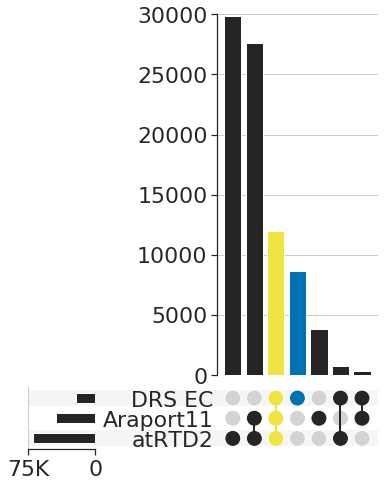

In [31]:
plot_upsetplot(
    udata_isoforms, order=order,
    totals_plot_elements=3,
    intersection_plot_elements=15,
    facecolor=facecolors,
    intersection_ylim=30_000,
    totals_xlim=75_000,
)
plt.tight_layout()
plt.savefig('splicing_upset_ec_only.svg')

In [84]:
def style_udata_isoforms(udata):

    def _style(x):
        c = '#555555' if x else '#ffffff'
        return f'background-color: {c}; color: {c}'
    udata.name = 'Isoforms'
    df = udata.sort_values(ascending=False).to_frame().reset_index()
    styled = df.style.applymap(
        _style,
        subset=pd.IndexSlice[:, ['atRTD2', 'Araport11', 'Illumina', 'DRS EC']]
    )
    styled = styled.applymap(
        lambda x: 'background-color: white',
        subset=pd.IndexSlice[:, ['Isoforms']]
    )
    return styled.hide_index()

In [86]:
s = style_udata_isoforms(udata_isoforms)
s.to_excel('isoform_upset_values.xlsx')
s

atRTD2,Araport11,DRS EC,Isoforms
True,False,False,29894
True,True,False,27585
True,True,True,11967
False,False,True,8659
False,True,False,3788
True,False,True,756
False,True,True,341
False,False,False,0


In [33]:
len(ec_ont_lnkd_splices.intersection(atrtd2_splices.union(araport11_splices)))

13064

In [34]:
len(ec_ont_lnkd_splices.difference(atrtd2_splices.union(araport11_splices)))

8659

In [35]:
def split_splices(annotated_splices):
    left = set()
    right = set()
    for splice in annotated_splices:
        chrom, start, end, strand = re.search(r'(\w+):(\d+)-(\d+)\(([+-])\)', splice).groups()
        left.add(f'{chrom}:{start}({strand})')
        right.add(f'{chrom}:{end}({strand})')
    return left, right

def novel_splices_vs_novel_combinations(isoforms, annotated_splices):
    novel_splices = set()
    novel_donor_acceptor_pairs = set()
    novel_combinations = set()
    annotated_left, annotated_right = split_splices(annotated_splices)
    for iso in isoforms:
        for splice in iso:
            if splice not in annotated_splices:
                novel_splices.add(iso)
                break
        else:
            if set(iso).issubset(annotated_splices):
                novel_combinations.add(iso)
            else:
                left, right = split_splices(iso)
                assert left.issubset(annotated_left)
                assert(right.issubset(annotated_right))
                novel_donor_acceptor_pairs.append(iso)
    return novel_splices, novel_donor_acceptor_pairs, novel_combinations

annotated_splices = set(list(it.chain(*list(araport11_splices.union(atrtd2_splices)))))

novel_splices, novel_donor_acceptor_pairs, novel_isoforms = novel_splices_vs_novel_combinations(
    ec_ont_lnkd_splices.difference(araport11_splices.union(atrtd2_splices)), annotated_splices
)

In [36]:
len(novel_splices), len(novel_donor_acceptor_pairs), len(novel_isoforms)

(4366, 0, 4293)

In [37]:
len(novel_isoforms) / (len(novel_splices) + len(novel_isoforms))

0.4957847326481118

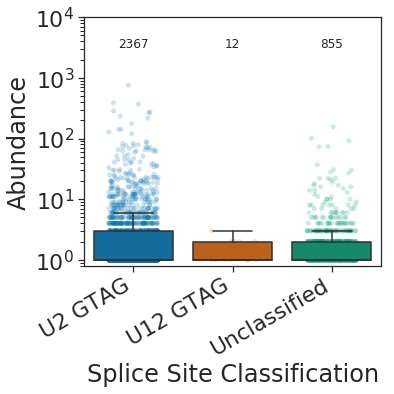

In [66]:
novel_splices = set(ec_ont_canon).intersection(ill_canon).difference(all_annotated)
novel_splices = pd.DataFrame.from_dict(
    {k: ec_ont_canon[k] for k in novel_splices},
    orient='index', columns=['splice_class', 'counts']
)
novel_splices['splice_class'] = novel_splices.splice_class.map(lambda x: x if x else 'Unclassified')
order=['U2 GTAG', 'U12 GTAG', 'Unclassified']

fig, ax = plt.subplots(figsize=(6, 6))
sns.stripplot(
    x='splice_class',
    y='counts',
    dodge=True, 
    jitter=0.25, alpha=0.2,
    data=novel_splices,
    order=order,
    ax=ax, zorder=0, rasterized=True,
)

sns.boxplot(
    x='splice_class',
    y='counts',
    data=novel_splices,
    order=order,
    ax=ax,
    fliersize=0,
    zorder=2,
)

counts = novel_splices.groupby(['splice_class']).count()['counts']
for i, a in enumerate(order):
    c = counts.loc[a]
    ax.annotate(xy=(i, 10**3.5), s=c, color="#252525", ha='center', fontsize=12)
    
                       
ax.set_ylim(top=10_000, bottom=0.8)
ax.set_yscale('log')
ax.set_xlabel('Splice Site Classification')
ax.set_ylabel('Abundance')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.savefig('drs_splice_abundance.svg')
plt.show()

In [72]:
novel_splices.groupby('splice_class').describe()

counts                                                
               count      mean        std  min  25%  50%  75%    max
splice_class                                                        
U12 GTAG        12.0  1.500000   0.674200  1.0  1.0  1.0  2.0    3.0
U2 GTAG       2367.0  5.079425  24.545652  1.0  1.0  1.0  3.0  757.0
Unclassified   855.0  2.683041   8.481493  1.0  1.0  1.0  2.0  157.0

In [ ]:
ec_ont_all = pd.DataFrame.from_dict(
    {**ec_ont_canon, **ec_ont_noncanon, **{'dummy': ['U12 ATAC', 10**6]}},
    orient='index', columns=['splice_class', 'counts']
)
ec_ont_all['splice_class'] = ec_ont_all.splice_class.map(lambda x: x if x else 'Unclassified')
ec_ont_all['is_annotated'] = ec_ont_all.index.to_series().isin(all_annotated).map({True: 'Annotated', False: 'Novel'})
ec_ont_all['is_illumina'] = ec_ont_all.index.to_series().isin(set(ill_canon).union(ill_noncanon)).map(
    {True: 'Illumina', False: 'Novel'})

fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(
    x='splice_class',
    y='counts',
    hue='is_annotated',
    dodge=True, 
    jitter=0.25, alpha=0.05,
    data=ec_ont_all,
    order=['U2 GTAG', 'U2 GCAG', 'U12 GTAG', 'U12 ATAC', 'Unclassified'],
    hue_order=['Annotated', 'Novel'],
    ax=ax, zorder=0, rasterized=True
)

sns.boxplot(
    x='splice_class',
    y='counts',
    hue='is_annotated',
    data=ec_ont_all,
    order=['U2 GTAG', 'U2 GCAG', 'U12 GTAG', 'U12 ATAC', 'Unclassified'],
    hue_order=['Annotated', 'Novel'],
    ax=ax,
    palette=sns.color_palette(['#c0e3f7', '#f4d2b7']),
    fliersize=0,
    zorder=2,
)


counts = ec_ont_all.groupby(['splice_class', 'is_annotated']).count()['counts']
y_pos = [10**5.5, 10**5]
for (k, i), (a, j) in it.product(zip(order, range(len(order))),
                                 zip(split_order, range(len(split_order)))):
    c = int(counts.loc[(k, a)])
    ax.annotate(xy=(i, y_pos[j]), s=c, color=pal[j], ha='center', fontsize=12)


ax.legend_.remove()

ax.set_yscale('log')
ax.set_xlabel('Splice Site Classification')
ax.set_ylabel('Abundance')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.savefig('error_corrected_drs_splice_abundance.svg')
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(11, 5), ncols=2, sharey=True)

ax = sns.countplot(
    x='splice_class',
    hue='is_annotated', 
    data=ont_all,
    order=['U2 GTAG', 'Unclassified'],
    ax=axes[0]
)
axes[0].legend_.remove()
axes[0].set_xlabel('')
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')

ax = sns.countplot(
    x='splice_class',
    hue='is_annotated', 
    data=ec_ont_all,
    order=['U2 GTAG', 'Unclassified'],
    ax=axes[1]
)
axes[1].set_xlabel('')
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
plt.show()

In [ ]:
sum(ont_all[ont_all.is_annotated != 'Novel'].splice_class == 'Unclassified') / len(ont_all[ont_all.is_annotated != 'Novel'])

In [ ]:
sum(ont_all[ont_all.is_annotated == 'Novel'].splice_class == 'Unclassified') / len(ont_all[ont_all.is_annotated == 'Novel'])

In [ ]:
sum(ont_all.is_annotated == 'Novel') / len(ont_all)

In [ ]:
sum(ec_ont_all.is_annotated == 'Novel') / len(ec_ont_all)

In [ ]:
ec_ont_all_m = ont_all.join(ec_ont_all, lsuffix='', rsuffix='_ec', how='outer')
ec_ont_all_m.drop('dummy', axis=0, inplace=True)
ec_ont_all_m.counts = ec_ont_all_m.counts.fillna(0)
ec_ont_all_m.counts_ec = ec_ont_all_m.counts_ec.fillna(0)
ec_ont_all_m.is_annotated = ec_ont_all_m.is_annotated.fillna(ec_ont_all_m.is_annotated_ec)
ec_ont_all_m.is_illumina = ec_ont_all_m.is_illumina.fillna(ec_ont_all_m.is_illumina_ec)
ec_ont_all_m['annot_or_illum'] = (
    (ec_ont_all_m.is_annotated == 'Annotated') * 2 + (ec_ont_all_m.is_illumina == 'Illumina')
).map({3: 'Annotated', 2: 'Annotated', 1: 'Illumina support', 0: 'Novel'})
ec_ont_all_m.splice_class = ec_ont_all_m.splice_class.fillna(ec_ont_all_m.splice_class_ec)
ec_ont_all_m['count_diff'] = ec_ont_all_m.counts_ec - ec_ont_all_m.counts
ec_ont_all_m.head(n=20)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.stripplot(
    x='splice_class',
    y='count_diff',
    hue='annot_or_illum',
    dodge=True, 
    jitter=0.25, alpha=0.05,
    data=ec_ont_all_m,
    order=['U2 GTAG', 'U2 GCAG', 'U12 GTAG', 'U12 ATAC', 'Unclassified'],
    hue_order=['Annotated', 'Illumina support', 'Novel'],
    ax=ax, zorder=0, rasterized=True
)
ax.set_ylim(-1000, 1000)

In [ ]:
ec_ont_all_m[(ec_ont_all_m.is_annotated == 'Novel') & (ec_ont_all_m.splice_class != "Unclassified")].sort_values('counts_ec', ascending=False).head()